# Dust Extinction

In [1]:
# remove after testing
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.ensemble import RandomForestClassifier
from mclearn.preprocessing import balanced_train_test_split
from mclearn.performance import (get_beta_parameters,
                                   beta_avg_inv_cdf)
from mclearn.viz import (plot_hex_map,
                         plot_balanced_accuracy_violin)
from mclearn.photometry import (reddening_correction_sfd98,
                                reddening_correction_sf11,
                                reddening_correction_w14,
                                correct_magnitudes,
                                compute_colours,
                                clean_up_subclasses)
from mclearn.classifier import train_classifier
from mclearn.tools import results_exist, load_results
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
fig_dir = '../thesis/figures/'
target_col = 'class'
features = ['psfMag_r', 'psf_u_g', 'psf_g_r', 'psf_r_i', 'psf_i_z',
            'petroMag_r', 'petro_u_g', 'petro_g_r', 'petro_r_i', 'petro_i_z',
            'petroRad_r']

In [3]:
sdss = pd.read_csv("../data/sdss_dr7_photometry_source.csv.gz", compression="gzip")

## Dust Extinction

In [4]:
# compute the three sets of reddening correction
A_u_sfd98, A_g_sfd98, A_r_sfd98, A_i_sfd98, A_z_sfd98 \
    = reddening_correction_sfd98(sdss['extinction_r'])
A_u_sf11, A_g_sf11, A_r_sf11, A_i_sf11, A_z_sf11 \
    = reddening_correction_sf11(sdss['extinction_r'])
A_u_w14, A_g_w14, A_r_w14, A_i_w14, A_z_w14 \
    = reddening_correction_w14(sdss['extinction_r'])

# useful variables
psf_magnitudes = ['psfMag_u', 'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z']
petro_magnitudes = ['petroMag_u', 'petroMag_g', 'petroMag_r', 'petroMag_i', 'petroMag_z']
sfd98_corrections = [A_u_sfd98, A_g_sfd98, A_r_sfd98, A_i_sfd98, A_z_sfd98]
sf11_corrections = [A_u_sf11, A_g_sf11, A_r_sf11, A_i_sf11, A_z_sf11]
w14_corrections = [A_u_w14, A_g_w14, A_r_w14, A_i_w14, A_z_w14]
colours = [('psfMag_u', 'psfMag_g'), ('psfMag_g', 'psfMag_r'), ('psfMag_r', 'psfMag_i'), ('psfMag_i', 'psfMag_z'),
           ('petroMag_u', 'petroMag_g'), ('petroMag_g', 'petroMag_r'), ('petroMag_r', 'petroMag_i'), ('petroMag_i', 'petroMag_z'),]

# calculate the corrected magnitudes
correct_magnitudes(sdss, psf_magnitudes, sfd98_corrections, '_sfd98')
correct_magnitudes(sdss, petro_magnitudes, sfd98_corrections, '_sfd98')
correct_magnitudes(sdss, psf_magnitudes, sf11_corrections, '_sf11')
correct_magnitudes(sdss, petro_magnitudes, sf11_corrections, '_sf11')
correct_magnitudes(sdss, psf_magnitudes, w14_corrections, '_w14')
correct_magnitudes(sdss, petro_magnitudes, w14_corrections, '_w14')

# calculate the corrected magnitudes
compute_colours(sdss, colours, '')
compute_colours(sdss, colours, '_sfd98')
compute_colours(sdss, colours, '_sf11')
compute_colours(sdss, colours, '_w14')

In [4]:
(sdss['extinction_r'] / 2.751).describe()

count    2801002.000000
mean           0.043105
std            0.071149
min            0.002320
25%            0.019528
50%            0.030231
75%            0.048321
max           24.065954
Name: extinction_r, dtype: float64

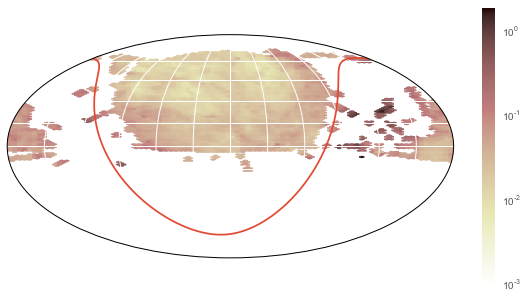

In [6]:
fig = plt.figure(figsize=(10,5))
ax = plot_hex_map(sdss['ra'], sdss['dec'], C=sdss['extinction_r'] / 2.751, reduce_C_function=np.mean,
                  origin=180, vmin=0.001, vmax=2, mincnt=1, milky_way=True, norm=LogNorm(), cmap=plt.cm.pink_r)
fig.savefig(fig_dir + '2_astro/ebv_map.png', bbox_inches='tight', dpi=300)

In [5]:
appendix_dir = fig_dir + 'appendix/'
train_size = 600000
test_size = 300000

uncorrected_features = ['ra', 'dec', 'psfMag_r', 'psf_u_g', 'psf_g_r', 'psf_r_i',
                        'psf_i_z', 'petroMag_r', 'petro_u_g', 'petro_g_r',
                        'petro_r_i', 'petro_i_z', 'petroRad_r']

sfd98_features = ['ra', 'dec', 'psfMag_r_sfd98', 'psf_u_g_sfd98', 'psf_g_r_sfd98', 'psf_r_i_sfd98',
                  'psf_i_z_sfd98', 'petroMag_r_sfd98', 'petro_u_g_sfd98', 'petro_g_r_sfd98',
                  'petro_r_i_sfd98', 'petro_i_z_sfd98', 'petroRad_r']

sf11_features = ['ra', 'dec', 'psfMag_r_sf11', 'psf_u_g_sf11', 'psf_g_r_sf11', 'psf_r_i_sf11',
                 'psf_i_z_sf11', 'petroMag_r_sf11', 'petro_u_g_sf11', 'petro_g_r_sf11',
                 'petro_r_i_sf11', 'petro_i_z_sf11', 'petroRad_r']

w14_features = ['ra', 'dec', 'psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']

Here's the confusion matrix:


Predicted              
                 Galaxy Quasar   Star
Actual Galaxy     97611   1844    545
       Quasar      2795  93269   3936
       Star        1730   8826  89444

The balanced accuracy rate is 93.44%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9557    0.9761    0.9658    100000
       Star     0.9523    0.8944    0.9225    100000
     Quasar     0.8973    0.9327    0.9147    100000

avg / total     0.9351    0.9344    0.9343    300000

Recall Maps of Galaxies, Stars, and Quasars, respectively:


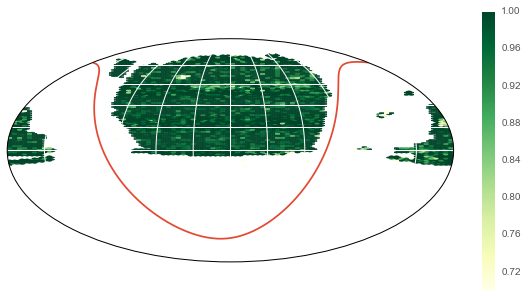

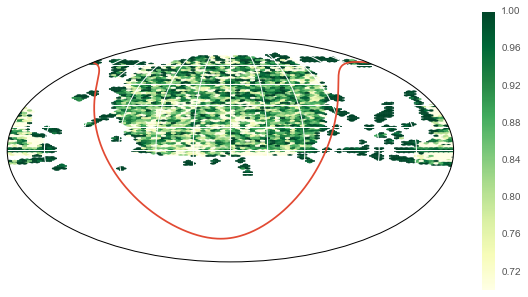

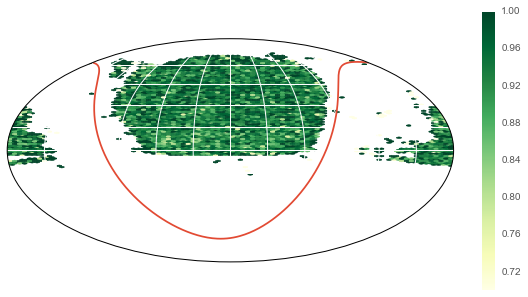

In [7]:
correct_baseline, confusion_baseline = train_classifier(sdss, uncorrected_features,
    target_col, train_size, test_size, 'uncorrected', fig_dir=appendix_dir, random_state=19)

Here's the confusion matrix:


Predicted              
                 Galaxy Quasar   Star
Actual Galaxy     97614   1865    521
       Quasar      2782  93247   3971
       Star        1696   8861  89443

The balanced accuracy rate is 93.43%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9561    0.9761    0.9660    100000
       Star     0.9522    0.8944    0.9224    100000
     Quasar     0.8968    0.9325    0.9143    100000

avg / total     0.9351    0.9343    0.9342    300000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


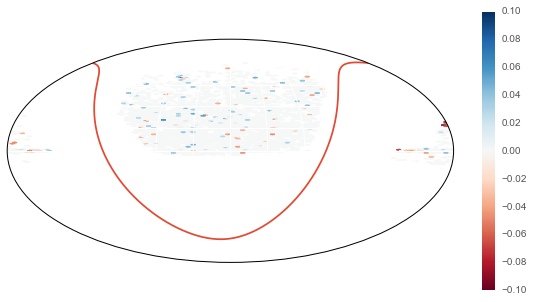

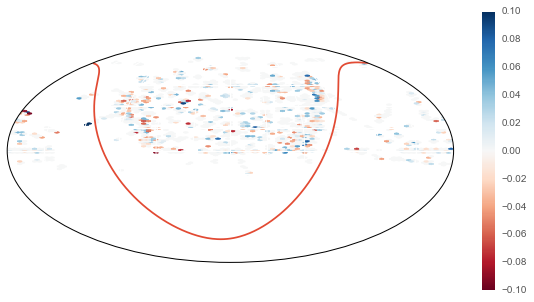

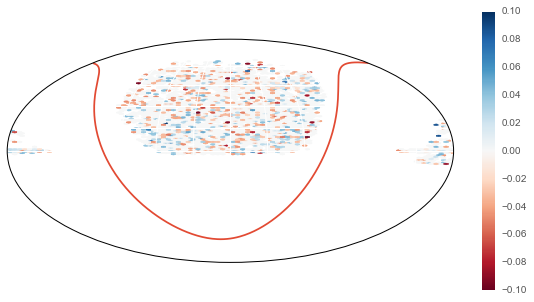

In [8]:
correct_sfd98, confusion_sfd98 = train_classifier(sdss, sfd98_features, target_col,
    train_size, test_size, 'sfd98', random_state=19, fig_dir=appendix_dir, correct_baseline=correct_baseline)

Here's the confusion matrix:


Predicted              
                 Galaxy Quasar   Star
Actual Galaxy     97602   1872    526
       Quasar      2789  93339   3872
       Star        1672   8892  89436

The balanced accuracy rate is 93.46%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9563    0.9760    0.9661    100000
       Star     0.9531    0.8944    0.9228    100000
     Quasar     0.8966    0.9334    0.9146    100000

avg / total     0.9353    0.9346    0.9345    300000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


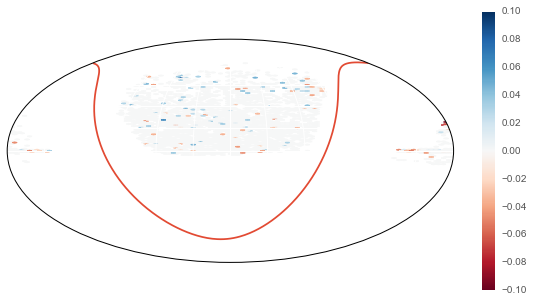

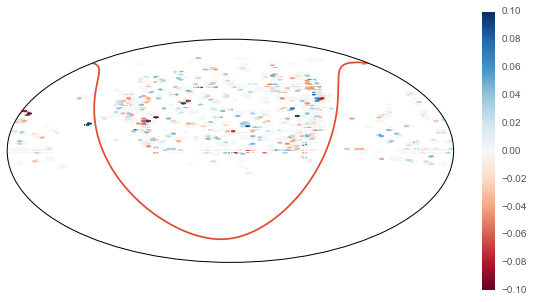

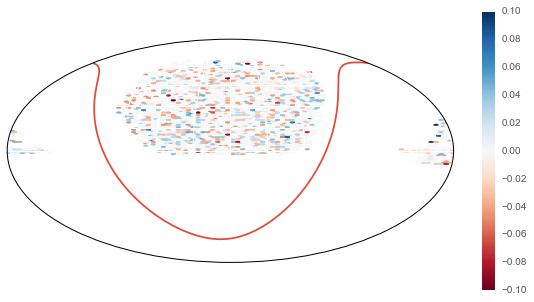

In [9]:
correct_sf11, confusion_sf11 = train_classifier(sdss, sf11_features, target_col,
    train_size, test_size, 'sf11', random_state=19, fig_dir=appendix_dir, correct_baseline=correct_baseline)

Here's the confusion matrix:


Predicted              
                 Galaxy Quasar   Star
Actual Galaxy     97588   1872    540
       Quasar      2786  93271   3943
       Star        1679   8908  89413

The balanced accuracy rate is 93.42%.
Classification report:
             precision    recall  f1-score   support

     Galaxy     0.9562    0.9759    0.9660    100000
       Star     0.9523    0.8941    0.9223    100000
     Quasar     0.8964    0.9327    0.9142    100000

avg / total     0.9350    0.9342    0.9341    300000

Recall Improvement Maps of Galaxies, Stars, and Quasars, respectively:


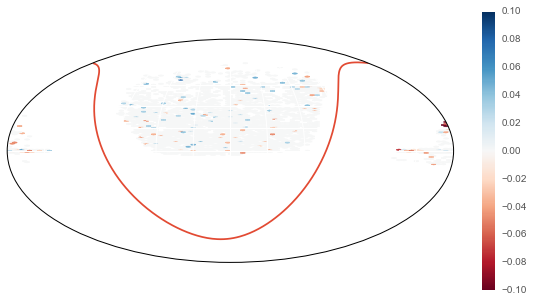

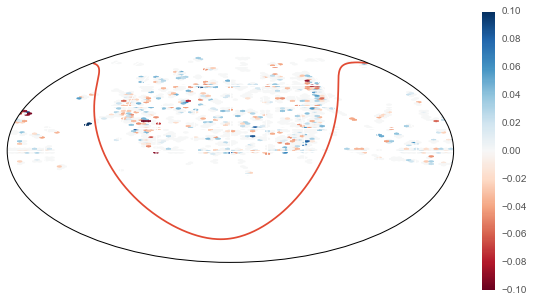

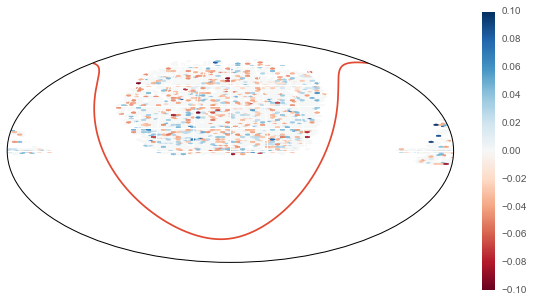

In [10]:
correct_w14, confusion_w14 = train_classifier(sdss, w14_features, target_col,
    train_size, test_size, 'w14', random_state=19, fig_dir=appendix_dir, correct_baseline=correct_baseline)

In [ ]:
pickle_file = '../pickle/03_dust_extinction/accuracy_samples.pickle'
if not results_exist(pickle_file):
    confusions = [confusion_baseline, confusion_sfd98, confusion_sf11, confusion_w14]
    accuracy_samples = []

    rs = np.random.RandomState(29)
    for confusion in confusions:
        parameters = get_beta_parameters(confusion)
        samples = [beta_avg_inv_cdf(rs.uniform(0, 1), parameters) for _ in range(100)]
        accuracy_samples.append(samples)

    with open(pickle_file, 'wb') as f:
        pickle.dump(accuracy_samples, f, protocol=4)

accuracy_samples = load_results(pickle_file)

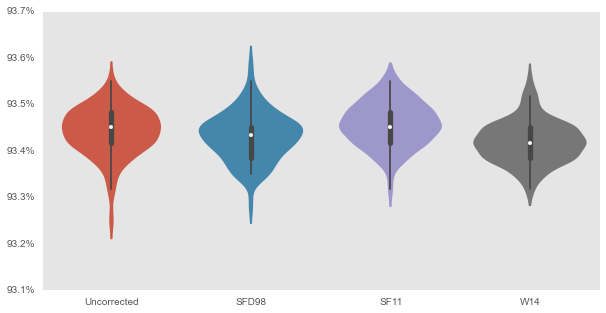

In [21]:
columns = ['Uncorrected', 'SFD98', 'SF11', 'W14']
accuracy_df = pd.DataFrame(accuracy_samples, index=columns).transpose()

fig = plt.figure(figsize=(10,5))
ax = plot_balanced_accuracy_violin(accuracy_df)
fig.savefig(fig_dir + '4_expt1/violin_reddening_correction.pdf', bbox_inches='tight')

In [22]:
for sample in accuracy_samples:
    print(pd.Series(sample).describe())

count    100.000000
mean       0.934413
std        0.000498
min        0.932500
25%        0.934167
50%        0.934500
75%        0.934833
max        0.935500
dtype: float64
count    100.000000
mean       0.934300
std        0.000504
min        0.932833
25%        0.933833
50%        0.934333
75%        0.934500
max        0.935833
dtype: float64
count    100.000000
mean       0.934560
std        0.000465
min        0.933167
25%        0.934167
50%        0.934500
75%        0.934833
max        0.935500
dtype: float64
count    100.000000
mean       0.934180
std        0.000439
min        0.933167
25%        0.933833
50%        0.934167
75%        0.934500
max        0.935500
dtype: float64
